In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import naive_bayes as nb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

%matplotlib inline

# Препроцессинг обучающего сета

In [277]:
data_train = pd.read_csv('train.csv')
data_train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Удаляем признаки, которые не несут смысловой нагрузки и не подлежат кодированию ввиду большого количества различных значений - айди, номер билета, номер каюты. Потенциально порт отправления, но нужно проверить его дополнительно.

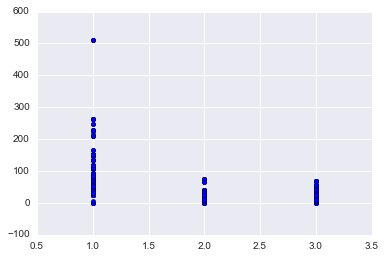

In [219]:
# data_train[['Pclass', 'Fare']].corr()
plt.scatter(data_train['Pclass'], data_train['Fare'])

Можно попробовать перемножить Pclass и Fare, так как видна обратная зависимость. Или перемножить Fare на обратные к Pclass.

In [11]:
data_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [12]:
data_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Несбалансированная выборка по количеству выживших и полу.

Заполним пропущенные значения, но сначала посмотрим в общую информацию по датафрейму.

In [220]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


In [233]:
data_train.describe()

/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_mapped,Age_filled
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,714.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,29.699118
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,14.526497
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400,0.000000,NaN
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200,0.000000,NaN
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000,1.000000,NaN
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,80.000000


In [286]:
data_train['Sex_mapped'] = data_train['Sex'].map({'male': 0, 'female': 1})
AgeMedians = data_train.pivot_table('Age', index=["Sex", "Pclass"], aggfunc='median')
data_train['Age_filled'] = data_train[['Sex', 
                                       'Age', 
                                       'Pclass']].apply(lambda x: 
                                                        AgeMedians[x.Sex, x.Pclass] 
                                                        if pd.isnull(x.Age) else 
                                                        x.Age, axis=1)

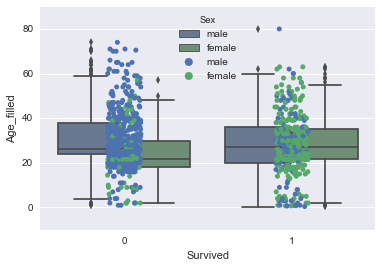

In [289]:
sns.boxplot(x='Survived', y='Age_filled', data=data_train, saturation=0.4, hue='Sex')
sns.stripplot(x="Survived", y="Age_filled", data=data_train, jitter=True, hue='Sex')

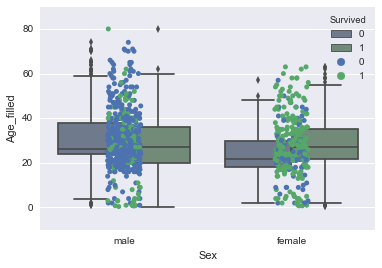

In [155]:
sns.boxplot(x='Sex', y='Age_filled', data=data_train, saturation=0.3, hue='Survived')
sns.stripplot(x="Sex", y="Age_filled", data=data_train, jitter=True, hue='Survived')

In [290]:
data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_mapped,Age_filled
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,22.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,38.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,26.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,35.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,35.0


Из гистограмм видно, что мужчины в основном не выжили, а женщины выжили. Кроме того, чем выше класс - тем больше выживших.

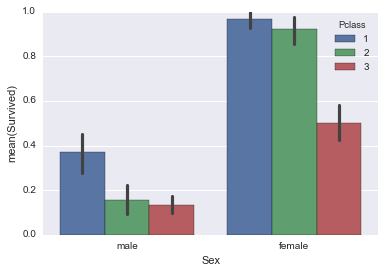

In [157]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data_train)

## Закодируем пол с помощью onehot кодирования и построим случайный лес. Первая модель.

In [160]:
enc = OneHotEncoder(sparse=False)
sex_train_encoded = enc.fit_transform(data_train['Sex_mapped'].values.reshape((-1, 1)))

In [161]:
rf_clf = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=0, class_weight='balanced')
rf_clf_train = np.hstack((data_train[['Pclass', 'Fare', 'Age_filled']].values, sex_train_encoded))
rf_clf_target = data_train['Survived'].values
rf_clf.fit(rf_clf_train, rf_clf_target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [291]:
data_test = pd.read_csv('test.csv')
data_test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
data_test['Sex_mapped'] = data_test['Sex'].map({'male': 0, 'female': 1})
data_test['Fare'].fillna(value=data_train['Fare'].mean(), inplace=True)
data_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_mapped
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,1
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,1


In [293]:
data_test['Age_filled'] = data_test[['Sex', 'Pclass', 'Age']].apply(lambda x: AgeMedians[x.Sex, x.Pclass] 
                                                                    if pd.isnull(x.Age) else x.Age, axis=1)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass        418 non-null int64
Name          418 non-null object
Sex           418 non-null object
Age           332 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Embarked      418 non-null object
Sex_mapped    418 non-null int64
Age_filled    418 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 32.7+ KB


In [264]:
sex_test_encoded = enc.transform(data_test['Sex_mapped'].values.reshape((-1, 1)))

In [265]:
rf_clf_test = np.hstack((data_test[['Pclass', 'Fare', 'Age_filled']].values, sex_test_encoded))
predictions = rf_clf.predict(rf_clf_test)

Write to file

In [269]:
output_df = pd.DataFrame(data={'PassengerId': np.arange(892, 892 + data_test.shape[0]), 'Survived': predictions})
output_df.to_csv('predictions0.csv', index=False)

In [270]:
T_AgeMedians = data_train.pivot_table('Age', index=["Sex", "Pclass"], aggfunc='median')
T_AgeMedians

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [276]:
T_AgeMedians['female', 2]

28.0